To install the necessary packages to run this notebook, you may use the `environment.yml` file supplied in the repository:
```bash
conda env create -f environment.yml
conda activate tcBFSTEM
```

Then, run `jupyter lab` to launch the Jupyter server and open the notebook. 

In [1]:
import sys
# Set this path to the location of the tcBFSTEM repository, if the notebook is being run from a different location
# sys.path.append("/hpc/projects/group.czii/yue.yu/MyPyLib/")

import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize

import os 

from EM import *
from PAD import *
from rigidregistration import stackregistration as stackreg


# Load data

Example data is avaliable on https://zenodo.org/records/10825339

Dataset `14_scan_x256_y256.raw` is used in this notebook, which was collected with a semiconvergence angle of 5.5 mrad and scan step size of 2.87 nm

In [ ]:
# Set this filepath to the location of the data file
pad = PAD.PADdata("~/Downloads/14_scan_x256_y256.raw", EMPAD=1, dim=256)

In [5]:
pad.data.shape

(125, 125, 256, 256)

In [6]:
pad.get_bf()

In [7]:
pad.ca = 5.5/1000 # semiconvergence angle in radians
pad.pixelsize = 2.88 # scan step size in nanometers

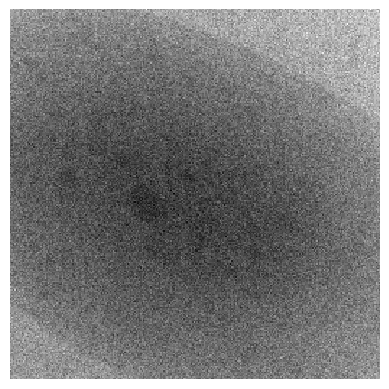

In [8]:
functions.show(pad.bf)

In [9]:
pad.get_center()

mask_bin1_rp9 = pad.make_mask(radius=0.9)
mask = mask_bin1_rp9

x,y=np.arange(np.shape(mask)[0]),np.arange(np.shape(mask)[1])
XX,YY=np.meshgrid(x,y)
XX,YY=XX.T,YY.T
xcoords_2d = (XX -pad.cbedcenterx)*(pad.ca/pad.cbedrad)    
ycoords_2d = (YY -pad.cbedcentery)*(pad.ca/pad.cbedrad) 
    
xcoords_bin1_rp9 = xcoords_2d[np.nonzero(mask)]
ycoords_bin1_rp9 = ycoords_2d[np.nonzero(mask)]

In [10]:
pad.make_stack(radius=0.9)
imgStack_bin1_rp9 = pad.stack

# Solve for shifts

In [11]:
pad.bin_cbedsTW4D(6)

In [12]:
pad.get_tcBF(radius=0.9, n=3, expand=1)

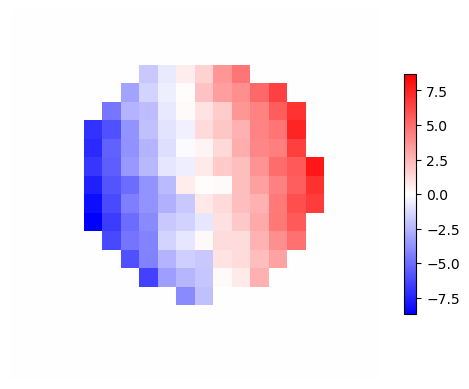

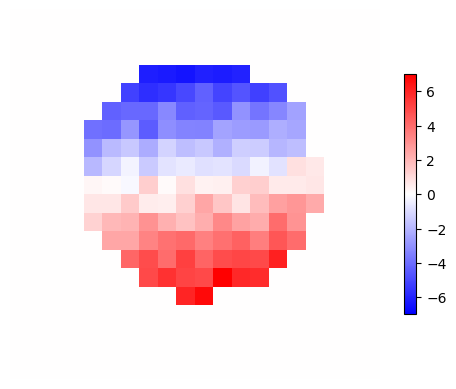

In [13]:
functions.show_map_lower(pad.xshiftmap)
functions.show_map_lower(pad.yshiftmap)

# Fit shifts to aberration function

In [14]:
def ddx_3rdOrder(tx, ty, C01a, C10, C12a, C12b, C21a, C21b, C23a, C23b, C30, C32a, C32b, C34a, C34b, theta):
    tx2=tx*np.cos(theta)-ty*np.sin(theta)
    ty2=tx*np.sin(theta)+ty*np.cos(theta)
    return C01a+C10*tx2+C12a*tx2+C12b*ty2+C21a*(tx2**2+(ty2**2)/3)+(2/3)*C21b*tx2*ty2+C23a*(tx2**2-ty2**2)-C23b*2*tx2*ty2+C30*(tx2**3+tx2*ty2**2)+C32a*(tx2**3)+C32b*(3/2*tx2**2*ty2+1/2*ty2**3)+C34a*(tx2**3-3*tx2*ty2**2)+C34b*(ty2**3-3*tx2**2*ty2)

def ddy_3rdOrder(tx, ty, C01b, C10, C12a, C12b, C21a, C21b, C23a, C23b, C30, C32a, C32b, C34a, C34b, theta):
    tx2=tx*np.cos(theta)-ty*np.sin(theta)
    ty2=tx*np.sin(theta)+ty*np.cos(theta)
    return C01b+C10*ty2-C12a*ty2+C12b*tx2+(2/3)*C21a*tx2*ty2+C21b*((tx2**2)/3+ty2**2)-2*C23a*tx2*ty2+C23b*(-tx2**2+ty2**2)+C30*(tx2**2*ty2+ty2**3)-C32a*(ty2**3)+C32b*((1/2)*tx2**3+(3/2)*tx2*ty2**2)+C34a*(-3*tx2**2*ty2+ty2**3)+C34b*(3*tx2*ty2**2-tx2**3)
 
def fit_aberrations_3rdOrder(pad, bnds = None):

    x,y=np.arange(np.shape(pad.tcmask)[0]),np.arange(np.shape(pad.tcmask)[1])
    XX,YY=np.meshgrid(x,y)
    XX,YY=XX.T,YY.T
    xcoords_2d = (XX - pad.cbedcenterx)*(pad.ca/pad.cbedrad)    
    ycoords_2d = (YY - pad.cbedcentery)*(pad.ca/pad.cbedrad) 
    
    xcoords = xcoords_2d[np.nonzero(pad.tcmask)]
    ycoords = ycoords_2d[np.nonzero(pad.tcmask)]
        
    #function to minimize for aberration coefficients
#     C01a,C01b,C10,C12a,C12b,C21a,C21b,C23a,C23b,C30,C32a,C32b,C34a,C34b
    err =  lambda C : np.sum((pad.xshiftmap[np.nonzero(pad.tcmask)]*pad.pixelsize-ddx_3rdOrder(xcoords, ycoords, C[0], C[2], C[3], C[4], C[5], C[6], C[7], C[8], C[9],C[10],C[11],C[12],C[13],C[14]))**2)+np.sum((pad.yshiftmap[np.nonzero(pad.tcmask)]*pad.pixelsize-ddy_3rdOrder(xcoords, ycoords, C[1], C[2], C[3], C[4], C[5], C[6], C[7], C[8], C[9],C[10],C[11],C[12],C[13],C[14]))**2)
    
    guess = (1.70785117e-02, 3.14510903e-02, 848.69605, 13.03355, -33.94756, -5191.39632, -14378.84838, -1417.63042, -3965.89846, -5364382.90998, 66001.02978, 250653.77245, -45584.04287, 284799.92335, 0.01121)
    methods = ['Powell', 'L-BFGS-B', 'TNC', 'SLSQP', 'trust-constr']

#     minerr = 300
    minerr =  4000 * pad.pixelsize * 10

    minmeth = ''
    minres = []

    for method in methods:
         try:
            print(method)
            res = minimize(err, guess,bounds=bnds, method=method)
            print(err(res.x))
            if err(res.x) < minerr:
                minerr = err(res.x)
                minmeth = method
                minres = res.x
                print('succeed!')
            else:                                                            
                print('fail!')
         except:
            print("there was an issue with this one")
    
    return minres


In [15]:
pad.tcmask = pad.make_mask(radius=0.95)
coeff_3rd = fit_aberrations_3rdOrder(pad)

Powell
4131.660095003888
succeed!
L-BFGS-B
5862.816384728478
fail!
TNC
5868.857313475935
fail!
SLSQP
5785.818556259014
fail!
trust-constr
5772.328457226052
fail!


In [16]:
minres = coeff_3rd

xcoords_bin1 = xcoords_bin1_rp9
ycoords_bin1 = ycoords_bin1_rp9
mask_bin1 = mask_bin1_rp9

imgShifts_x_3rd = ddx_3rdOrder(xcoords_bin1, ycoords_bin1, minres[0], minres[2], minres[3], minres[4], minres[5], minres[6], minres[7], minres[8], minres[9], minres[10], minres[11], minres[12], minres[13], minres[14])/pad.pixelsize 
imgShifts_y_3rd = ddy_3rdOrder(xcoords_bin1, ycoords_bin1, minres[1], minres[2], minres[3], minres[4], minres[5], minres[6], minres[7], minres[8], minres[9], minres[10], minres[11], minres[12], minres[13], minres[14])/pad.pixelsize 

xFitMap_3rd = np.zeros_like(mask_bin1, dtype='double')
xFitMap_3rd[np.nonzero(mask_bin1)] = imgShifts_x_3rd

yFitMap_3rd = np.zeros_like(mask_bin1, dtype='double')
yFitMap_3rd[np.nonzero(mask_bin1)] = imgShifts_y_3rd

In [17]:
imgShifts_x_3rd = xFitMap_3rd[np.nonzero(mask_bin1_rp9)]
imgShifts_y_3rd = yFitMap_3rd[np.nonzero(mask_bin1_rp9)]

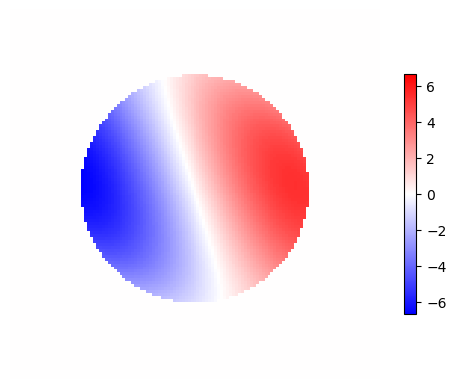

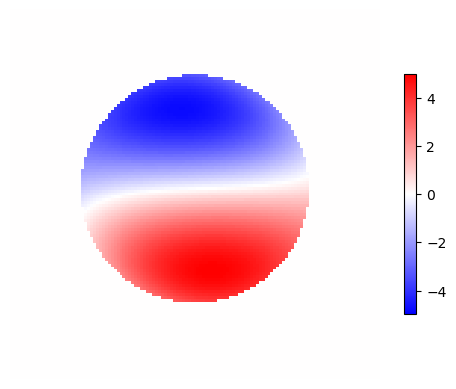

In [18]:
functions.show_map_lower(
    xFitMap_3rd
)
functions.show_map_lower(
    yFitMap_3rd
)


# Generate upsampled tcBF image

In [19]:
im_expand = PADutil.apply_shift_expand(
    imgStack_bin1_rp9, imgShifts_y_3rd, imgShifts_x_3rd, 
    4
)

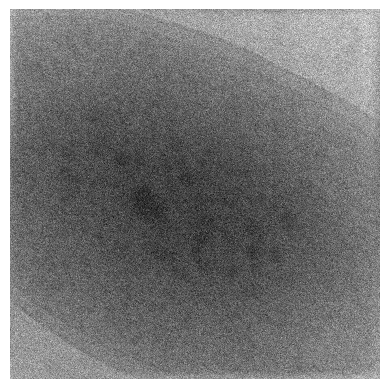

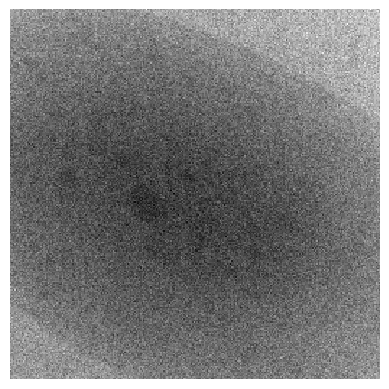

In [20]:
# Compare upsampled image with previous result
functions.show(im_expand[0]/im_expand[1])
functions.show(pad.bf)